# Logistic regression with pystan

In this notebook, we use PyStan to classify synthetic data. We have included the examples for:
 1. Binary univariate classification
 2. Binary bivariate classification

## 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import stan
import arviz as az

In [2]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

## 1. Binary univariate classification

In [3]:
N = 50

In [4]:
#generate two types of data
x1 = np.random.normal(2.5, 1, N)
x2 = np.random.normal(4, 1, N)
data = pd.DataFrame([x1, x2]).T
data.head()

,0,1
0,2.313765,4.720777
1,2.932622,3.902009
2,3.441138,3.646485
3,2.645369,4.297325
4,1.039589,4.583808


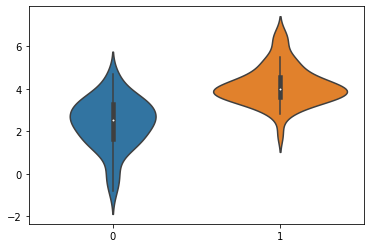

In [5]:
sns.violinplot(data=data)
plt.show()

In [6]:
x_0 = np.concatenate([x1, x2]).reshape((2*N, 1))
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [7]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta; 
  #vector[N] bd;
  #bd = -alpha/beta;
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ bernoulli_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

In [8]:
y_0.shape, x_0.shape

((100,), (100, 1))

In [9]:
data = {                                                                                             
    'N': 2*N,                                                                                        
    'K': 1,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

In [10]:
posterior = stan.build(code, data=data, random_seed=1)


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [11]:
fit = posterior.sample(num_chains=4, num_samples=2000)


Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000172 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.72 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [12]:
df = fit.to_frame()  # pandas `DataFrame, requires pandas
print(df.describe().T)

                count       mean        std        min        25%        50%  \
parameters                                                                     
lp__           8000.0 -39.844888   1.016847 -46.579040 -40.238649 -39.534508   
accept_stat__  8000.0   0.929112   0.108351   0.079476   0.908077   0.974878   
stepsize__     8000.0   0.126816   0.017876   0.109154   0.117797   0.120717   
treedepth__    8000.0   2.800250   1.086622   1.000000   2.000000   3.000000   
n_leapfrog__   8000.0  12.805000  10.290443   1.000000   3.000000  11.000000   
...               ...        ...        ...        ...        ...        ...   
linpred.96     8000.0   3.917975   0.815645   1.255995   3.354449   3.885823   
linpred.97     8000.0  -0.209546   0.294741  -1.247706  -0.402313  -0.206505   
linpred.98     8000.0   2.470895   0.547623   0.614515   2.091832   2.446947   
linpred.99     8000.0   0.840591   0.313941  -0.297474   0.627047   0.833238   
linpred.100    8000.0   1.405540   0.378

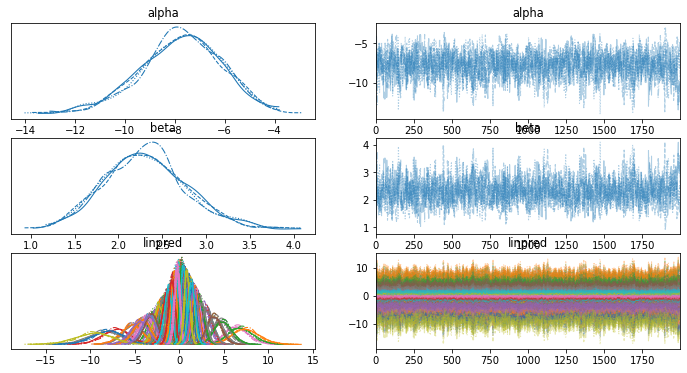

In [13]:
az.plot_trace(fit)
plt.show()

## 2. Binary bivariate classification

Generate bidimensional data from two different normal distributions.

In [14]:
N = 50

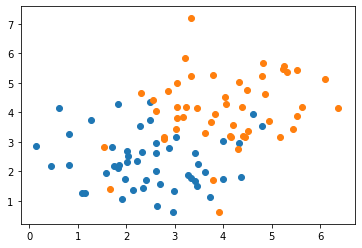

In [15]:
x1 = np.random.normal([2.5,2.5],[1,1], [N,2])
x2 = np.random.normal([4,4],[1,1], [50,2])
plt.scatter(x1[:,0], x1[:,1])
plt.scatter(x2[:,0], x2[:,1])
plt.show()

In [16]:
x_0 = np.concatenate([x1, x2])
y_0 = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

In [17]:
data = {                                                                                             
    'N': 2*N,                                                                                        
    'K': 2,                                                                                        
    'y': y_0,                                                                                     
    'X': x_0                                                                                             
}  

The same code is valid for more than one independent variable.

In [18]:
posterior = stan.build(code, data=data, random_seed=1)


Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 15, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_06hv8nbu/model_kalyq7h2.stan', line 16, column 2: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be do

In [19]:
fit = posterior.sample(num_chains=4, num_samples=2000)


Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!


In [20]:
df = fit.to_frame()  # pandas `DataFrame, requires pandas
print(df.describe().T)

                count       mean        std        min        25%        50%  \
parameters                                                                     
lp__           8000.0 -37.725886   1.246871 -46.205696 -38.284623 -37.422468   
accept_stat__  8000.0   0.939577   0.091307   0.193151   0.918614   0.977343   
stepsize__     8000.0   0.152664   0.011221   0.143026   0.143636   0.148363   
treedepth__    8000.0   3.607750   1.053342   1.000000   3.000000   4.000000   
n_leapfrog__   8000.0  18.758500  10.401788   1.000000  11.000000  15.000000   
...               ...        ...        ...        ...        ...        ...   
linpred.96     8000.0   3.498800   0.772480   1.216420   2.954089   3.454107   
linpred.97     8000.0   0.995507   0.529610  -0.821356   0.636610   0.984413   
linpred.98     8000.0   1.057064   0.612769  -1.013150   0.642327   1.049107   
linpred.99     8000.0   0.913797   0.380305  -0.386177   0.654361   0.898922   
linpred.100    8000.0   5.855279   1.186

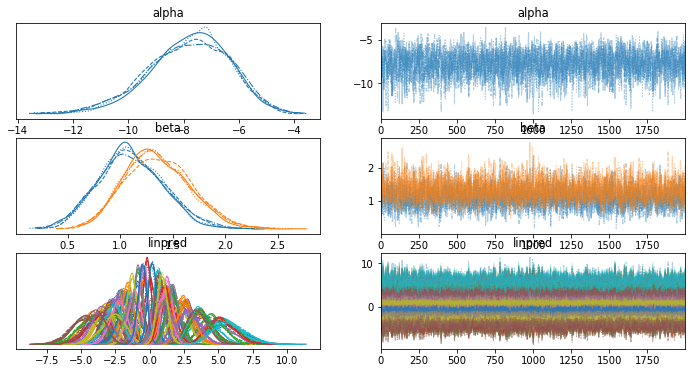

In [21]:
az.plot_trace(fit)
plt.show()